# Molecular fingerprints demo for SIH

A basic demo showing the scale of the problem setting


In [37]:
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
from seaborn import kdeplot

In [9]:
X = sparse.load_npz('./morgan.npz').astype(bool)

print(X.shape)

(358938, 32768)


There are `358,938` instances. Each instance is featurized as a 32768 dimensional vector. 

For regularized estimators, the high dimensionality is no problem. But for non-regularized estimators the high dimensionality can lead to issues. The fingerprint is easily folded down to a smaller dimensionality:

In [18]:
def fold_fingerprints(feature_matrix):
    """Folds a fingerprint matrix by bitwise OR.
    (scipy will perform the bitwise OR because the input data is bool,
    and will not cast to int when two Trues are added."""

    ncols = feature_matrix.shape[1]
    return feature_matrix[:,:ncols//2] + feature_matrix[:,ncols//2:]


print('Original size:', X.shape[1])

print('Folded 1 time:', fold_fingerprints(X).shape[1])

print('Folded 2 times:', fold_fingerprints(fold_fingerprints(X)).shape[1])

print('Folded 3 times:', fold_fingerprints(fold_fingerprints(fold_fingerprints(X))).shape[1])



Original size: 32768
Folded 1 time: 16384
Folded 2 times: 8192
Folded 3 times: 4096


The reason folding like this is generally OK is because the fingerprints are highly sparse, making bit-collisions quite rare until you get to smaller sizes (anything below 4096 or so). 

Sparsity:

In [24]:
sparsity = X.sum() / (X.shape[0] * X.shape[1])
print(f'Feature matrix is {sparsity} dense')

Feature matrix is 0.001654688136779759 dense


Each instance has around 50 "on" bits:


Text(0, 0.5, 'Density')

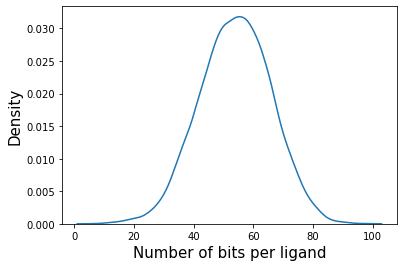

In [60]:
samples_idx = np.random.choice(X.shape[0], 10000)
samples = X[samples_idx]
n_bits = np.array(samples.sum(1))

fsize =15
kdeplot(n_bits.flatten())
plt.xlabel('Number of bits per ligand',fontsize=fsize)
plt.ylabel('Density',fontsize=fsize)

# The label matrix

The labels are multi-label (multiple possible labels, and any given instance can have more than one of those labels). This data set has `344` labels. 

Most instances have a single label. But the label matrix is incompletely sampled - it's really a Positive-Unlabelled Learning setting (or graph learning, like recommender systems).

In practice, whenever we use linear learners like LogReg or SVC, people use the OvR approximation. Random forests or network-graph algorithms might have an advantage here due to correct handling of multilabel setting. 

Preliminary data show that you can use the network graph to embed the feature vectors into a new space that emphasises similarity of orthogonal features - kind of like metric learning. 

In [62]:
y = sparse.load_npz('interaction_matrix_pchembl.npz')
print(y.shape)
y[0].toarray()

(358938, 344)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 

Text(0, 0.5, 'Density')

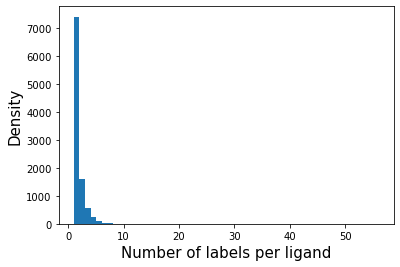

In [96]:

##most ligands have only one label, but a good fraction are multilabel:

samples_idx = np.random.choice(y.shape[0], 10000)
samples = y[samples_idx]
n_labels = np.array(samples.sum(1))


plt.hist(n_labels.flatten(), bins=np.arange(n_labels.max())+1)
plt.xlabel('Number of labels per ligand',fontsize=fsize)
plt.ylabel('Density', fontsize=fsize)

# Label imbalance:

In [94]:
num_labels = np.array(y.sum(0))[0]
num_labels[:15]

array([1587., 3087., 1949.,  497.,  480., 1719., 1513.,  640., 2705.,
        458., 1267.,  582.,  612., 2195.,  795.])

Text(0.5, 0, 'Number of instances')

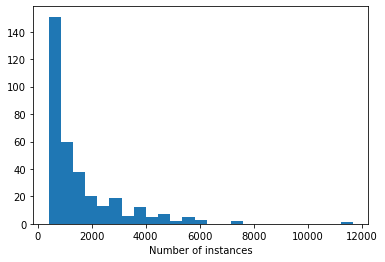

In [95]:
plt.hist(num_labels, bins=25)
plt.xlabel('Number of instances')

# Jaccard coefficient (or Dice)

Jaccard and Dice coefficient can be done very quickly on high dimensional vectors, because scipy ignores all zeros when doing the dot product. The time to calculate distances scales with the number of features per instance, not the total number of possible features

I generally exclude targets with less than `~150` instances. This particular dataset has at least 500 instances per label, and up to 15,000 instances, but this upper limit could be increased to ~30,000

Remember, when using the OvR approximation this can result in `500:350,000` imbalance.

In a recent publication I showed how to sub-sample the data to maintain about a `1:10`ratio. 


In [65]:
def fast_jaccard(X, Y=None):
    """credit: https://stackoverflow.com/questions/32805916/compute-jaccard-distances-on-sparse-matrix"""
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y)
    assert X.shape[1] == Y.shape[1]

    X = X.astype(bool).astype(int)
    Y = Y.astype(bool).astype(int)
    
    intersect = X.dot(Y.T)
    x_sum = X.sum(axis=1).A1
    y_sum = Y.sum(axis=1).A1
    xx, yy = np.meshgrid(x_sum, y_sum)
    union = ((xx + yy).T - intersect)
    return (1 - intersect / union).A

def fast_dice(X, Y=None):
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X).astype(bool).astype(int)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y).astype(bool).astype(int)
            
    intersect = X.dot(Y.T)
    #cardinality = X.sum(1).A
    cardinality_X = X.getnnz(1)[:,None] #slightly faster on large matrices - 13s vs 16s for 12k x 12k
    cardinality_Y = Y.getnnz(1) #slightly faster on large matrices - 13s vs 16s for 12k x 12k
    return (1-(2*intersect) / (cardinality_X+cardinality_Y.T)).A


Take a random sample of ligands and find the pairwise Jaccard distance between them:

In [70]:
sample_idx = np.random.choice(X.shape[0], 5000)

samples = X[sample_idx]

In [71]:
fast_jaccard(samples)

array([[0.        , 0.9245283 , 0.8677686 , ..., 0.89565217, 0.91891892,
        0.95402299],
       [0.9245283 , 0.        , 0.91      , ..., 0.84883721, 0.85      ,
        0.89473684],
       [0.8677686 , 0.91      , 0.        , ..., 0.92035398, 0.91509434,
        0.9382716 ],
       ...,
       [0.89565217, 0.84883721, 0.92035398, ..., 0.        , 0.88297872,
        0.94444444],
       [0.91891892, 0.85      , 0.91509434, ..., 0.88297872, 0.        ,
        0.9047619 ],
       [0.95402299, 0.89473684, 0.9382716 , ..., 0.94444444, 0.9047619 ,
        0.        ]])

In [72]:
%%timeit
fast_jaccard(samples)

1.68 s ± 84.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
%%timeit
fast_jaccard(samples[:1000])

41.1 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:
distances = fast_jaccard(samples)

In [84]:
j,k = np.triu_indices(1000,1)

upper_triangle = distances[j,k]

Text(0, 0.5, 'Density')

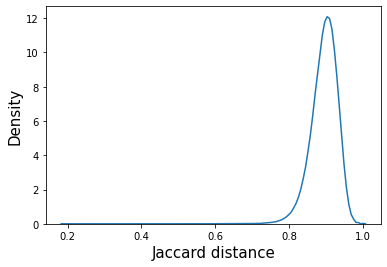

In [86]:
kdeplot(upper_triangle)
plt.xlabel('Jaccard distance', fontsize=fsize)
plt.ylabel('Density', fontsize=fsize)